# Sonecule TVOSon Time-variant Oscillators Sonification

Using a bank of oscillators to represent the channels of multivariate data:

- mapping each value to a displacement of the pitch
  - ampmode=="val"/"absval": mapping each value or absolute value to amplitude
  - ampmode=="change": mapping the absolute change to amplitude
- parameters:
  - base_pitch: midi note number of the first channel
  - delta_pitch: 
    - if int: channel separation in semitones
    - if array: offsets in 
  

## Data Preparation

In [144]:
%run prepare-data.ipynb

## Sonecule pre-development

In [145]:
import sonecules as sn
sn.startup()
sn.pb = sn.playback
ctx = sn.gcc()
import sc3nb as scn
from pya import Asig
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)
%matplotlib widget

<IPython.core.display.Javascript object>

SC already started
sclang already started
scsynth already started


Asig('_arrayindexed_arrayindexed'): 5 x 200 @ 50Hz = 4.000s cn=['0', '1', '2', '5', '9']

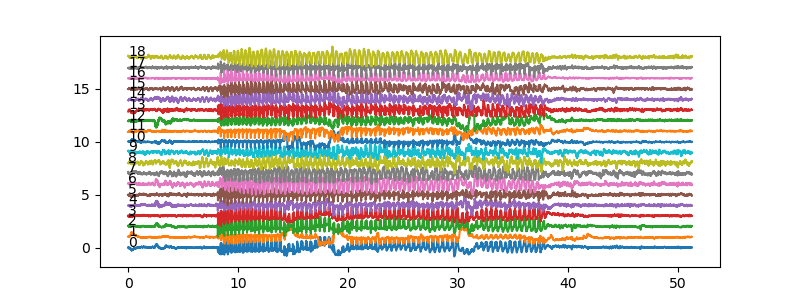

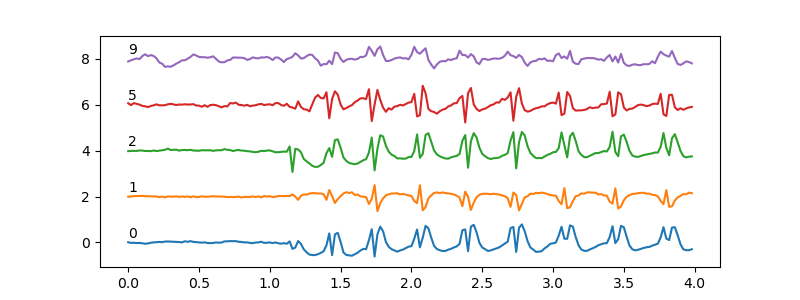

In [146]:
# select test data for sonecule
dasig = Asig(eeg_data, sr=250)
plt.figure(); dasig.plot(offset=1)

data = dasig[{7:11}, [0,1,2,5,9]][::5]
plt.figure(); data.plot(offset=2)

In [151]:
# create synth for tvosc
scn.SynthDef("tvosc-sine-1ch", 
"""{ | out=0, freq=400, amp=0.1, pan=0, lg=0.1 | 
    var sig = SinOsc.ar(freq.lag(lg), mul: amp.lag(lg));
    Out.ar(out, Pan2.ar(sig, pan));
}""").add();

In [164]:
# set mesonic backend latency

sn.pb().processor.latency = 0.1

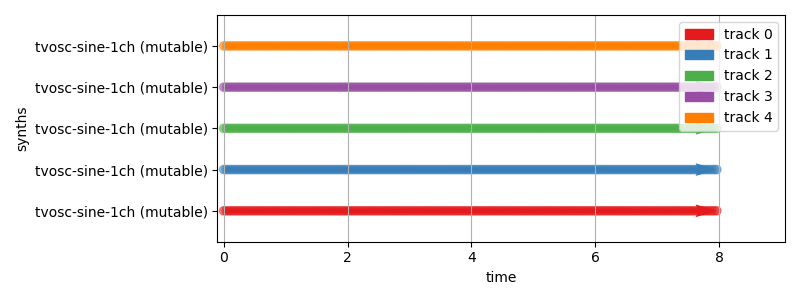

In [166]:

# create synths
syns = []
for i in range(data.channels):
    syns.append(ctx.synths.create(name="tvosc-sine-1ch", track=i,  mutable=True))
syns

ctx.reset()

# here schedule function, with argument for replace default to true
rate = 0.5
maxonset = -1
base_pitch = 50
delta_pitch = 7
ampmode = "absval" # "change"

# start syns (oscillators)
with ctx.at(time=0):
    for i, syn in enumerate(syns):
        syn.start(freq=300+40*i, amp=0.01, pan=0, lg=0.1)
data.samples, data.get_duration(), data.sr

# modulate oscillators
for i, r in enumerate(data.sig):
    onset = i / data.sr / rate
    change = r - data.sig[max(0, i-1)]
    with ctx.at(time=onset):
        for i, el in enumerate(r):
            center_pitch = base_pitch + i * delta_pitch 
            syns[i].freq = scn.midicps(center_pitch + scn.linlin(el, -1, 1, -0.5*delta_pitch, + 0.5*delta_pitch))
            if ampmode == "change":
                syns[i].amp = scn.linlin(abs(change[i]), 0, 0.8, 0, 0.1)
            elif ampmode == "absamp":
                syns[i].amp = scn.linlin(abs(el), 0, 0.8, 0, 0.1)
    if onset > maxonset:
        maxonset = onset

# stop oscillators
with ctx.at(time=maxonset):
    for syn in syns:
        syn.stop()

# plot timeline and start sonification playback
ctx.timeline.plot()
sn.pb().start()

## Implementation

In [2]:
from mesonic.synth import Synth
from sonecules.base import Sonecule


In [5]:
class SoneculeXY(Sonecule):
    ...

## Usage / Demo Snippets